In [1]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import time
import math
import pickle
from IPython.display import display, clear_output

In [2]:
episode, step = 0, 0

In [3]:
# -----------------------------
# Q-Network for DQN Agent
# -----------------------------
class QNetwork(nn.Module):
    def __init__(self, input_channels, num_actions, grid_size):
        super(QNetwork, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, H, W]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),              # [B, 64, H, W]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),              # [B, 64, H, W]
            nn.ReLU()
        )

        # Flatten after conv layers
        self.fc_input_size = None  # Placeholder, will be set dynamically
        self.fc = nn.Sequential(
            nn.Linear(64 * grid_size * grid_size, 512),  # Update based on actual grid size
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)


# -----------------------------
# Prioritized Replay Buffer
# -----------------------------
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        Args:
            capacity (int): Maximum number of transitions to store.
            alpha (float): How much prioritization is used 
                           (0 = no prioritization, 1 = full prioritization).
        """
        self.capacity = capacity
        self.buffer = []             # List to store experiences.
        self.priorities = []         # List to store priorities.
        self.alpha = alpha
        self.pos = 0

    def add(self, experience):
        """Adds an experience to the buffer with maximum priority."""
        # If the buffer is not full, append the new experience;
        # otherwise, replace the oldest one (circular buffer).
        max_priority = max(self.priorities) if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
            self.priorities.append(max_priority)
        else:
            self.buffer[self.pos] = experience
            self.priorities[self.pos] = max_priority
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        """
        Samples a batch of experiences with probabilities proportional to their priorities.
        
        Args:
            batch_size (int): Number of samples to draw.
            beta (float): Importance-sampling, from initial value increasing to 1.
        
        Returns:
            samples: List of sampled experiences.
            indices: The indices of the sampled experiences.
            weights: Importance sampling weights for the batch.
        """
        if len(self.buffer) == 0:
            return [], [], []

        prios = np.array(self.priorities, dtype=np.float32)
        probs = prios ** self.alpha
        probs_sum = probs.sum()
        if probs_sum == 0 or np.isnan(probs_sum):
            probs = np.ones_like(probs) / len(probs)
        else:
            probs /= probs_sum

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[i] for i in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()  # Normalize

        return samples, indices, weights
    

    def update_priorities(self, indices, new_priorities):
        """
        Updates the priorities of sampled experiences.
        
        Args:
            indices (list of int): The indices of the experiences to update.
            new_priorities (list of float): The new priority for each corresponding experience.
        """
        for idx, priority in zip(indices, new_priorities):
            self.priorities[idx] = priority

    def size(self):
        return len(self.buffer)

    def save(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump((self.buffer, self.priorities, self.pos), f)
        print(f"Replay buffer saved to {filepath}")

    def load(self, filepath):
        with open(filepath, 'rb') as f:
            self.buffer, self.priorities, self.pos = pickle.load(f)
        print(f"Replay buffer loaded from {filepath}")


# -----------------------------
# DQN Agent
# -----------------------------
class DQNAgent:
    def __init__(self, action_space, state_space, grid_size, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.1, 
                 epsilon_decay=0.995, batch_size=64, buffer_size=10000):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_space = action_space
        self.state_space = state_space
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.step = 0  # <--- Track steps here

        input_channels = 3  # Agent, rewards, enemies

        self.q_network = QNetwork(input_channels, action_space, grid_size).to(self.device)
        self.target_network = QNetwork(input_channels, action_space, grid_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.buffer = PrioritizedReplayBuffer(buffer_size)

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_space)
        
        # Convert to shape [1, C, H, W] assuming 3-channel input (C=3)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # [1, 3, H, W]
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()



    def train(self, beta=0.4):
        if self.buffer.size() < self.batch_size:
            return

        batch, indices, weights = self.buffer.sample(self.batch_size, beta)
        if not batch:
            return  # Safety check

        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert batch to tensors
        # Shape: [B, 3, H, W] assuming 3-channel grid input
        states = torch.FloatTensor(np.array(states)).to(self.device)  # [B, 3, H, W]
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)  # [B, 3, H, W]
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)  # [B, 1]
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)  # [B, 1]
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)  # [B, 1]
        weights = torch.FloatTensor(weights).unsqueeze(1).to(self.device)  # [B, 1]

        # Forward pass
        q_values = self.q_network(states).gather(1, actions)  # [B, 1]

        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]  # [B, 1]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        td_errors = q_values - target_q_values
        loss = (weights * td_errors.pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities
        new_priorities = td_errors.abs().detach().cpu().numpy().flatten() + 1e-6
        self.buffer.update_priorities(indices, new_priorities)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay




    def save(self, filepath, episode, step):
        torch.save({
            'policy_net_state_dict': self.q_network.state_dict(),
            'target_net_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'episode': episode,
            'step': step,
            'epsilon': self.epsilon
        }, filepath)

    def load(self, filepath):
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        episode = checkpoint.get('episode', 0)
        step = checkpoint.get('step', 0)
        self.epsilon = checkpoint.get('epsilon', 1.0)
        print(f"Loaded model from {filepath} | episode: {episode} | step: {step} | epsilon: {self.epsilon:.4f}")
        return episode, step


In [4]:
# -------------------------------------------
# Collect & Avoid Environment (gym.Env subclass)
# -------------------------------------------

class CollectAvoidEnv(gym.Env):
    def __init__(self, grid_size=15, num_rewards=5, num_enemies=3, enemy_random_move_ratio=0.5, max_steps=1000):
        super(CollectAvoidEnv, self).__init__()

        self.grid_size = grid_size
        self.num_rewards = num_rewards
        self.num_enemies = num_enemies
        self.enemy_random_move_ratio = enemy_random_move_ratio
        self.reward_positions = []
        self.enemy_positions = []
        self.agent_pos = None
        self.max_steps = max_steps
        self.current_step = 0

        # Action space: 5 discrete actions
        self.action_space = spaces.Discrete(5)

        # Observation space: 3-channel grid (agent, rewards, enemies)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0,
            shape=(3, self.grid_size, self.grid_size),
            dtype=np.float32
        )

        # Plotting setup
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.ax.set_xlim(0, self.grid_size - 1)
        self.ax.set_ylim(0, self.grid_size - 1)
        self.ax.set_xticks(range(self.grid_size))
        self.ax.set_yticks(range(self.grid_size))
        self.ax.grid(True)

        self.reset()

    def reset(self):
        from math import sqrt

        # Reset the step counter
        self.current_step = 0

        # Randomly place rewards on the grid, avoiding overlap
        self.reward_positions = [self._random_empty_cell([]) for _ in range(self.num_rewards)]

        # Randomly place the agent on the grid, avoiding rewards
        self.agent_pos = self._random_empty_cell(self.reward_positions)

        # Calculate the minimum required distance between agent and each enemy
        # 0.6 * grid_size * sqrt(2) is roughly 60% of the max diagonal distance
        min_dist = 0.6 * self.grid_size * sqrt(2)

        self.enemy_positions = []
        for _ in range(self.num_enemies):
            while True:
                # Generate a candidate position for the enemy, avoiding overlaps
                candidate = self._random_empty_cell(
                    self.reward_positions + self.enemy_positions + [self.agent_pos]
                )

                # Compute Euclidean distance from the agent
                dist = sqrt((candidate[0] - self.agent_pos[0])**2 +
                            (candidate[1] - self.agent_pos[1])**2)

                # Accept candidate only if it's far enough from the agent
                if dist >= min_dist:
                    self.enemy_positions.append(candidate)
                    break

        # Return the initial observation/state
        return self._get_state()


    def step(self, action, episode, step):
        self.current_step += 1
        prev_agent_pos = self.agent_pos

        # Move agent
        if action == 0:  # stay
            new_pos = self.agent_pos
        elif action == 1:  # up
            new_pos = (max(self.agent_pos[0] - 1, 0), self.agent_pos[1])
        elif action == 2:  # down
            new_pos = (min(self.agent_pos[0] + 1, self.grid_size - 1), self.agent_pos[1])
        elif action == 3:  # left
            new_pos = (self.agent_pos[0], max(self.agent_pos[1] - 1, 0))
        elif action == 4:  # right
            new_pos = (self.agent_pos[0], min(self.agent_pos[1] + 1, self.grid_size - 1))

        self.agent_pos = new_pos

        # Move enemies
        self._move_enemies()

        # Compute reward and check if agent is caught by an enemy or has collected all rewards
        reward = self._compute_reward(prev_agent_pos)
        done = self.agent_pos in self.enemy_positions or len(self.reward_positions) == 0 or self.current_step >= self.max_steps # Terminate if caught by enemy or all rewards are collected

        # Render environment
        self.render(episode, step, reward)
        return self._get_state(), reward, done, {}

    def _get_state(self):
        state = np.zeros((3, self.grid_size, self.grid_size), dtype=np.float32)

        # Agent in channel 0
        state[0, self.agent_pos[0], self.agent_pos[1]] = 1.0

        # Rewards in channel 1
        for r in self.reward_positions:
            state[1, r[0], r[1]] = 1.0

        # Enemies in channel 2
        for e in self.enemy_positions:
            state[2, e[0], e[1]] = 1.0

        return state

    def _compute_reward(self, prev_agent_pos):
        reward = 0.0

        if self.agent_pos in self.reward_positions:
            self.reward_positions.remove(self.agent_pos)
            reward += 3.0

        # Reward for being near remaining rewards
        for rx, ry in self.reward_positions:
            dist = abs(self.agent_pos[0] - rx) + abs(self.agent_pos[1] - ry)
            if dist == 1: reward += 0.2
            elif dist == 2: reward += 0.15
            elif dist == 3: reward += 0.1

        # Penalty for being near enemies
        for ex, ey in self.enemy_positions:
            edist = abs(self.agent_pos[0] - ex) + abs(self.agent_pos[1] - ey)
            if edist == 1: reward -= 1
            elif edist == 2: reward -= 0.5
            elif edist == 3: reward -= 0.3
            elif edist == 4: reward -= 0.2

        # Reward for increasing distance from enemies
        if self.enemy_positions:
            prev_avg = np.mean([abs(prev_agent_pos[0] - ex) + abs(prev_agent_pos[1] - ey) for ex, ey in self.enemy_positions])
            curr_avg = np.mean([abs(self.agent_pos[0] - ex) + abs(self.agent_pos[1] - ey) for ex, ey in self.enemy_positions])
            if curr_avg > prev_avg: reward += 0.3
            elif curr_avg < prev_avg: reward -= 0.3

        return reward

    def _move_enemies(self):
        for i in range(len(self.enemy_positions)):
            x, y = self.enemy_positions[i]
            ax, ay = self.agent_pos

            if random.random() < (1 - self.enemy_random_move_ratio):
                if ax > x: x += 1
                elif ax < x: x -= 1
                if ay > y: y += 1
                elif ay < y: y -= 1
            else:
                dx, dy = random.choice([(0, 1), (1, 0), (0, -1), (-1, 0)])
                x = max(0, min(self.grid_size - 1, x + dx))
                y = max(0, min(self.grid_size - 1, y + dy))

            self.enemy_positions[i] = (x, y)

    def _random_empty_cell(self, excluded_cells):
        while True:
            cell = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if cell not in excluded_cells:
                return cell

    def render(self, episode, step, reward=None):
        self.ax.clear()
        self.ax.set_xlim(0, self.grid_size - 1)
        self.ax.set_ylim(0, self.grid_size - 1)
        self.ax.set_xticks(range(self.grid_size))
        self.ax.set_yticks(range(self.grid_size))
        self.ax.grid(True)

        self.ax.plot(self.agent_pos[0], self.agent_pos[1], 'bo', markersize=10)
        for r_pos in self.reward_positions:
            self.ax.plot(r_pos[0], r_pos[1], 'go', markersize=10)
        for e_pos in self.enemy_positions:
            self.ax.plot(e_pos[0], e_pos[1], 'ro', markersize=10)

        self.ax.text(0.5, self.grid_size - 1, f'Episode: {episode}, Step: {step}',
                     horizontalalignment='center', verticalalignment='top', fontsize=12, color='black', weight='bold')

        if reward is not None:
            reward_color = 'green' if reward > 0 else 'red' if reward < 0 else 'black'
            self.ax.text(0.5, self.grid_size - 2, f'Reward: {reward:.2f}',
                         horizontalalignment='center', verticalalignment='top', fontsize=12, color=reward_color, weight='bold')

        clear_output(wait=True)
        display(self.fig)



KeyboardInterrupt: 

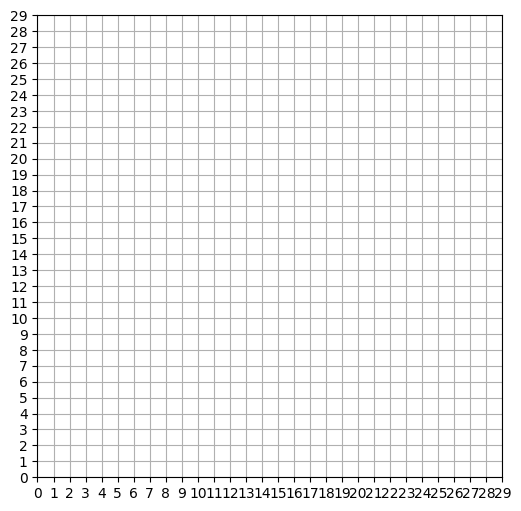

In [5]:
# -------------------------------------------
# Train the Agent
# -------------------------------------------

""" Input Variables """
GRID_SIZE = 30
NUM_REWARDS = 12
NUM_ENEMIES = 1
ENEMY_RANDOM_MOVE_RATIO = 0.6
NUMBER_OF_EPISODES = 10000
MAX_STEPS_PER_EPISODE= 700

LEARNING_RATE = 0.001
GAMMA = 0.95  # 0: only immediate reward matters ; 1.0: future rewards are just as important as immediate ones.
EPSILON = 1.0   # initial value for weighting random over policy in taking actions
EPSILON_MIN = 0.2
EPSILON_DECAY = 0.9999  # multiplies random action chance with this factor after every training
BATCH_SIZE = 8  # number of samples to take from the replay buffer for training
BUFFER_SIZE = 10000

# Define the annealing parameters for beta (Prioritized Replay Buffer)
BETA_START = 0.4  # Starting value for beta (usually smaller)
BEAT_FRAMES = 10  # Number of frames after which beta will reach 1.0
TOTAL_FRAMES = NUMBER_OF_EPISODES * 100  # Total frames in the training

RESUME_TRAINING = False
MODEL_PATH = r"E:\Git_repos\RL_playground\CollectAndAvoid\trained_models\cnn_models\dqn_cnn_model_1.pth"
BUFFER_PATH = r"E:\Git_repos\RL_playground\CollectAndAvoid\trained_models\cnn_models\buffer_CNN_1.pth"
""" END of Input Variables """

env = CollectAvoidEnv(grid_size=GRID_SIZE, num_rewards=NUM_REWARDS, num_enemies=NUM_ENEMIES, enemy_random_move_ratio=ENEMY_RANDOM_MOVE_RATIO, max_steps=MAX_STEPS_PER_EPISODE)
agent = DQNAgent(env.action_space.n, np.prod(env.observation_space.shape), GRID_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON,
                 epsilon_min=EPSILON_MIN, epsilon_decay=EPSILON_DECAY, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

start_episode = 0
start_step = 0

# Try loading an existing model
if RESUME_TRAINING:
    try:
         start_episode, start_step = agent.load(MODEL_PATH)
    except FileNotFoundError:
        print("No saved model found, starting from scratch.")

# Try loading an existing buffer
if RESUME_TRAINING:
    try:
        agent.buffer.load(BUFFER_PATH)
    except FileNotFoundError:
        print("No saved buffer found, starting with empty buffer.")


for episode in range(start_episode, NUMBER_OF_EPISODES):
    state = env.reset()
    done = False
    step = 0

    # Calculate beta for the current training step (frame_idx)
    frame_idx = episode * 50 + step  # Adjust this according to your setup
    beta = min(1.0, BETA_START + (BEAT_FRAMES - BETA_START) * frame_idx / TOTAL_FRAMES)
    
    while not done:
        action = agent.act(state)  # Get action from your agent
        next_state, reward, done, _ = env.step(action, episode, step)
        step += 1
        agent.buffer.add((state, action, reward, next_state, float(done)))

        print(f"E{episode} S{step} | reward: {reward:.3f} | epsilon: {agent.epsilon:.3f} | beta: {beta:.3f}")

        agent.train(beta=beta)
        # if episode > 2000:
        #     time.sleep(0.1)
        
    # Every 10 episodes, update target network and save model and buffer
    if episode % 10 == 0:
        agent.update_target_network()
        agent.save(MODEL_PATH, episode, step)
        agent.buffer.save(BUFFER_PATH)
        print("Model and Buffer saved.")
        
    print(f"Episode {episode + 1} finished")

# Save the final model and buffer after training is complete
agent.save(MODEL_PATH, episode, step)
agent.buffer.save(BUFFER_PATH)
print("Training complete, model and buffer saved.")

env.close()
